# Step 0: Load Packages and Libraries

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

import os
from scipy.sparse import coo_matrix


import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# evaluvation 
from sklearn.metrics import mean_squared_error, precision_score, recall_score, f1_score

# Step 1: Data Loading and Preprocessing

In [36]:
# Read your dataset 
train_data = pd.read_csv('original_data.tsv', sep='\t')
train_data.columns

Index(['Uniq Id', 'Crawl Timestamp', 'Dataset Origin', 'Product Id',
       'Product Barcode', 'Product Company Type Source',
       'Product Brand Source', 'Product Brand Normalised Source',
       'Product Name Source', 'Match Rank', 'Match Score', 'Match Type',
       'Retailer', 'Product Category', 'Product Brand', 'Product Name',
       'Product Price', 'Sku', 'Upc', 'Product Url', 'Market',
       'Product Description', 'Product Currency',
       'Product Available Inventory', 'Product Image Url',
       'Product Model Number', 'Product Tags', 'Product Contents',
       'Product Rating', 'Product Reviews Count', 'Bsr', 'Joining Key'],
      dtype='object')

In [37]:
# feature selection 
train_data = train_data[['Uniq Id','Product Id', 'Product Rating', 'Product Reviews Count', 'Product Category', 'Product Brand', 'Product Name', 'Product Image Url', 'Product Description', 'Product Tags']]
train_data.head(3)

,Uniq Id,Product Id,Product Rating,Product Reviews Count,Product Category,Product Brand,Product Name,Product Image Url,Product Description,Product Tags
0,1705736792d82aa2f2d3caf1c07c53f4,2e17bf4acecdece67fc00f07ad62c910,NaN,NaN,Premium Beauty > Premium Makeup > Premium Nail...,OPI,"OPI Infinite Shine, Nail Lacquer Nail Polish, ...",https://i5.walmartimages.com/asr/0e1f4c51-c1a4...,NaN,"OPI Infinite Shine, Nail Lacquer Nail Polish, ..."
1,95a9fe6f4810fcfc7ff244fd06784f11,076e5854a62dd283c253d6bae415af1f,NaN,NaN,Beauty > Hair Care > Hair Color > Auburn Hair ...,Nice'n Easy,"Nice n Easy Permanent Color, 111 Natural Mediu...",https://i5.walmartimages.com/asr/9c8e42e4-13a5...,Pack of 3 Pack of 3 for the UPC: 381519000201 ...,"Nice 'n Easy Permanent Color, 111 Natural Medi..."
2,8d4d0330178d3ed181b15a4102b287f2,8a4fe5d9c7a6ed26cc44d785a454b124,4.5,29221.0,Beauty > Hair Care > Hair Color > Permanent Ha...,Clairol,Clairol Nice N Easy Permanent Color 7/106A Nat...,https://i5.walmartimages.com/asr/e3a601c2-6a2b...,This Clairol Nice N Easy Permanent Color gives...,Clairol Nice 'N Easy Permanent Color 7/106A Na...


In [38]:
train_data.shape

(5000, 10)

In [39]:
train_data.isnull().sum()

Uniq Id                     0
Product Id                  0
Product Rating           2806
Product Reviews Count    1654
Product Category           10
Product Brand              13
Product Name                0
Product Image Url           0
Product Description      1127
Product Tags                0
dtype: int64

In [40]:
# handell null values 
train_data = train_data.fillna({
    'Product Rating': 0,
    'Product Reviews Count': 0,
    'Product Category': 'Unknown',
    'Product Brand': 'Unknown',
    'Product Description': ''
})

In [41]:
train_data.isnull().sum()

Uniq Id                  0
Product Id               0
Product Rating           0
Product Reviews Count    0
Product Category         0
Product Brand            0
Product Name             0
Product Image Url        0
Product Description      0
Product Tags             0
dtype: int64

In [42]:
train_data.duplicated().sum()

0

In [43]:
# change column names 
column_name_mapping = {
    'Uniq Id': 'ID',
    'Product Id': 'ProdID',
    'Product Rating': 'Rating',
    'Product Reviews Count': 'ReviewCount',
    'Product Category': 'Category',
    'Product Brand': 'Brand',
    'Product Name': 'Name',
    'Product Image Url': 'ImageURL',
    'Product Description': 'Description',
    'Product Tags': 'Tags',
}
# Rename the columns using the mapping
train_data.rename(columns=column_name_mapping, inplace=True)

In [44]:
train_data.columns

Index(['ID', 'ProdID', 'Rating', 'ReviewCount', 'Category', 'Brand', 'Name',
       'ImageURL', 'Description', 'Tags'],
      dtype='object')

In [45]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID           5000 non-null   object 
 1   ProdID       5000 non-null   object 
 2   Rating       5000 non-null   float64
 3   ReviewCount  5000 non-null   float64
 4   Category     5000 non-null   object 
 5   Brand        5000 non-null   object 
 6   Name         5000 non-null   object 
 7   ImageURL     5000 non-null   object 
 8   Description  5000 non-null   object 
 9   Tags         5000 non-null   object 
dtypes: float64(2), object(8)
memory usage: 390.8+ KB


In [46]:
train_data.describe()

,Rating,ReviewCount
count,5000.000000,5000.000000
mean,1.884480,382.137000
std,2.192057,2050.994303
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,3.000000
75%,4.400000,60.250000
max,5.000000,29242.000000


In [47]:
train_data[["ID","ProdID"]].head(5)

,ID,ProdID
0,1705736792d82aa2f2d3caf1c07c53f4,2e17bf4acecdece67fc00f07ad62c910
1,95a9fe6f4810fcfc7ff244fd06784f11,076e5854a62dd283c253d6bae415af1f
2,8d4d0330178d3ed181b15a4102b287f2,8a4fe5d9c7a6ed26cc44d785a454b124
3,fddc4df45b35efd886794b261f730c51,03b5fb878a33eadff8b033419eab9669
4,0990cf89a59ca6a0460349a3e4f51d42,ce3d761e57d6ccad80619297b5b1bcbc


In [48]:
train_data['ID'] = train_data['ID'].str.extract(r'(\d+)').astype(float)
train_data['ProdID'] = train_data['ProdID'].str.extract(r'(\d+)').astype(float)

In [49]:
train_data[["ID","ProdID"]].head(5)

,ID,ProdID
0,1.705737e+09,2.0
1,9.500000e+01,76.0
2,8.000000e+00,8.0
3,4.000000e+00,3.0
4,9.900000e+02,3.0


In [50]:
# save the preprocessed data 
train_data.to_csv('models/clean_data.csv', index=False)

# EDA 

In [51]:
train_data.head(10)

,ID,ProdID,Rating,ReviewCount,Category,Brand,Name,ImageURL,Description,Tags
0,1.705737e+09,2.000000e+00,0.0,0.0,Premium Beauty > Premium Makeup > Premium Nail...,OPI,"OPI Infinite Shine, Nail Lacquer Nail Polish, ...",https://i5.walmartimages.com/asr/0e1f4c51-c1a4...,,"OPI Infinite Shine, Nail Lacquer Nail Polish, ..."
1,9.500000e+01,7.600000e+01,0.0,0.0,Beauty > Hair Care > Hair Color > Auburn Hair ...,Nice'n Easy,"Nice n Easy Permanent Color, 111 Natural Mediu...",https://i5.walmartimages.com/asr/9c8e42e4-13a5...,Pack of 3 Pack of 3 for the UPC: 381519000201 ...,"Nice 'n Easy Permanent Color, 111 Natural Medi..."
2,8.000000e+00,8.000000e+00,4.5,29221.0,Beauty > Hair Care > Hair Color > Permanent Ha...,Clairol,Clairol Nice N Easy Permanent Color 7/106A Nat...,https://i5.walmartimages.com/asr/e3a601c2-6a2b...,This Clairol Nice N Easy Permanent Color gives...,Clairol Nice 'N Easy Permanent Color 7/106A Na...
3,4.000000e+00,3.000000e+00,0.0,0.0,Beauty > Makeup > Lip,Kokie Cosmetics,"Kokie Professional Matte Lipstick, Hot Berry, ...",https://i5.walmartimages.com/asr/25b4b467-bc61...,Calling all matte lip lovers! Indulge in our r...,"Kokie Professional Matte Lipstick, Hot Berry, ..."
4,9.900000e+02,3.000000e+00,0.0,131.0,Seasonal > Stock Up Essentials > Personal Care...,Gillette,"Gillette TRAC II Plus Razor Blade Refills, Fit...",https://i5.walmartimages.com/asr/1a2ebb06-cd01...,"In 1971, Gillette introduced the Trac II razor...","Gillette TRAC II Plus Razor Blade Refills, Fit..."
5,2.620000e+02,7.569141e+09,4.6,52.0,Beauty > Hair Care > Hair Care Brands > Old Sp...,Old Spice,Old Spice Artisan Styling High Hold Matte Fini...,https://i5.walmartimages.com/asr/73214b95-72ce...,Old Spice Artisan Molding Clay is a Mens Styli...,Old Spice Artisan Styling High Hold Matte Fini...
6,5.224642e+09,3.710000e+02,4.3,10.0,Personal Care > Oral Care > Kids Oral Care,Colgate,"Colgate My First Baby and Toddler Toothpaste, ...",https://i5.walmartimages.com/asr/d28b16f4-1bd4...,Colgate My First Baby and Toddler Toothpaste i...,"Colgate My First Baby and Toddler Toothpaste, ..."
7,6.000000e+00,0.000000e+00,0.0,0.0,Beauty > Makeup > Nails,BMC,BMC Bright and Loud Cream Gel Lacquer Polish S...,https://i5.walmartimages.com/asr/93f8bbf3-2dfd...,"Lights, Sick Beats, and Epic Gel Polish! We pr...",BMC Bright and Loud Cream Gel Lacquer Polish S...
8,5.070000e+02,1.007940e+42,5.0,1.0,Beauty > Hair Care > Hair Care Brands > Suave,Suave,Suave Extra Hold 7 Shaping Mousse 9 oz (Pack o...,https://i5.walmartimages.com/asr/05f5ba16-335d...,Free Shipping Pack of 6 Pack of 6 for the UPC:...,Suave Extra Hold 7 Shaping Mousse 9 oz (Pack o...
9,3.200000e+01,1.030521e+42,0.0,950.0,Health > Lip Care > Vaseline,Vaseline,(3 pack) Vaseline Lip Therapy Tinted Lip Balm ...,https://i5.walmartimages.com/asr/6fced36e-5459...,Vaseline Lip Therapy Lip Balm Mini Rosy is cli...,(3 pack) Vaseline Lip Therapy Tinted Lip Balm ...


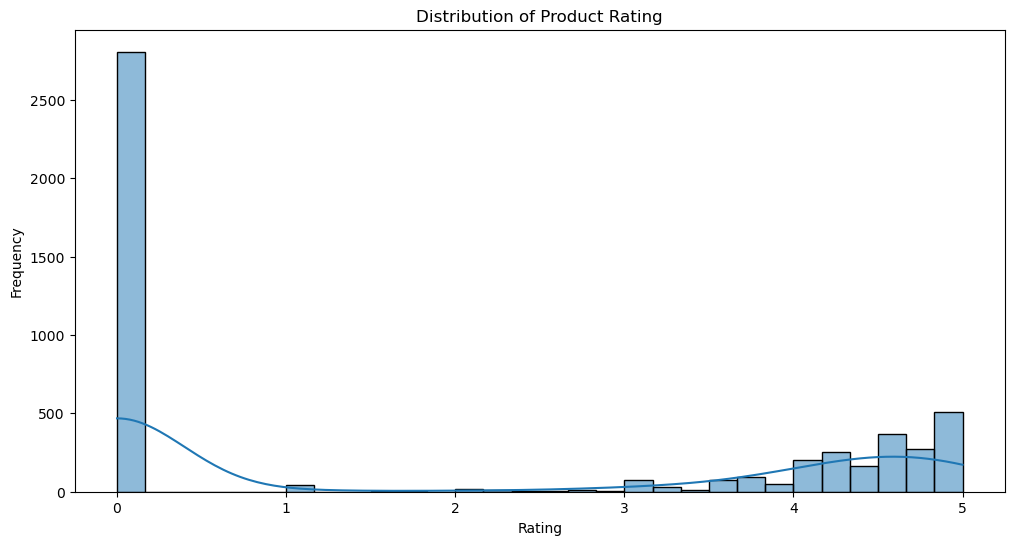

In [52]:
plt.figure(figsize=(12, 6))
sns.histplot(train_data['Rating'], bins=30, kde=True)
plt.title('Distribution of Product Rating')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()


In [53]:
# Basic statistics
num_users = train_data['ID'].nunique()
num_items = train_data['ProdID'].nunique()
num_ratings = train_data['Rating'].nunique()
print(f"Number of unique users: {num_users}")
print(f"Number of unique items: {num_items}")
print(f"Number of unique ratings: {num_ratings}")

Number of unique users: 1721
Number of unique items: 1697
Number of unique ratings: 36


In [54]:
most_popular_by_rating = train_data.groupby('Name')['Rating'].mean().idxmax()
print(f"The most popular item by rating is: {most_popular_by_rating}")


The most popular item by rating is: ($100 Value) Peter Thomas Roth Thermal Therapy Duo Skincare Kit


In [55]:
most_popular_by_reviews = train_data.loc[train_data['ReviewCount'].idxmax(), 'Name']
print(f"The most reviewed item:  {most_popular_by_reviews}")


The most reviewed item:  Clairol Nice n Easy Sun-Kissed Permanent Hair Color, 9G Light Golden Beach Blonde, 1 Kit


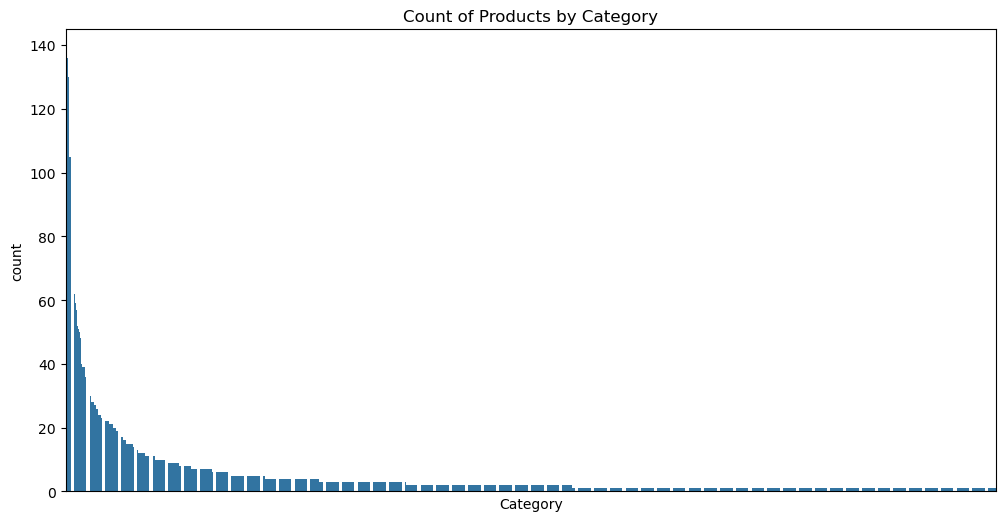

In [56]:
plt.figure(figsize=(12, 6))
sns.countplot(data=train_data, x='Category', order=train_data['Category'].value_counts().index)
plt.xticks([])
plt.title('Count of Products by Category')
plt.show()


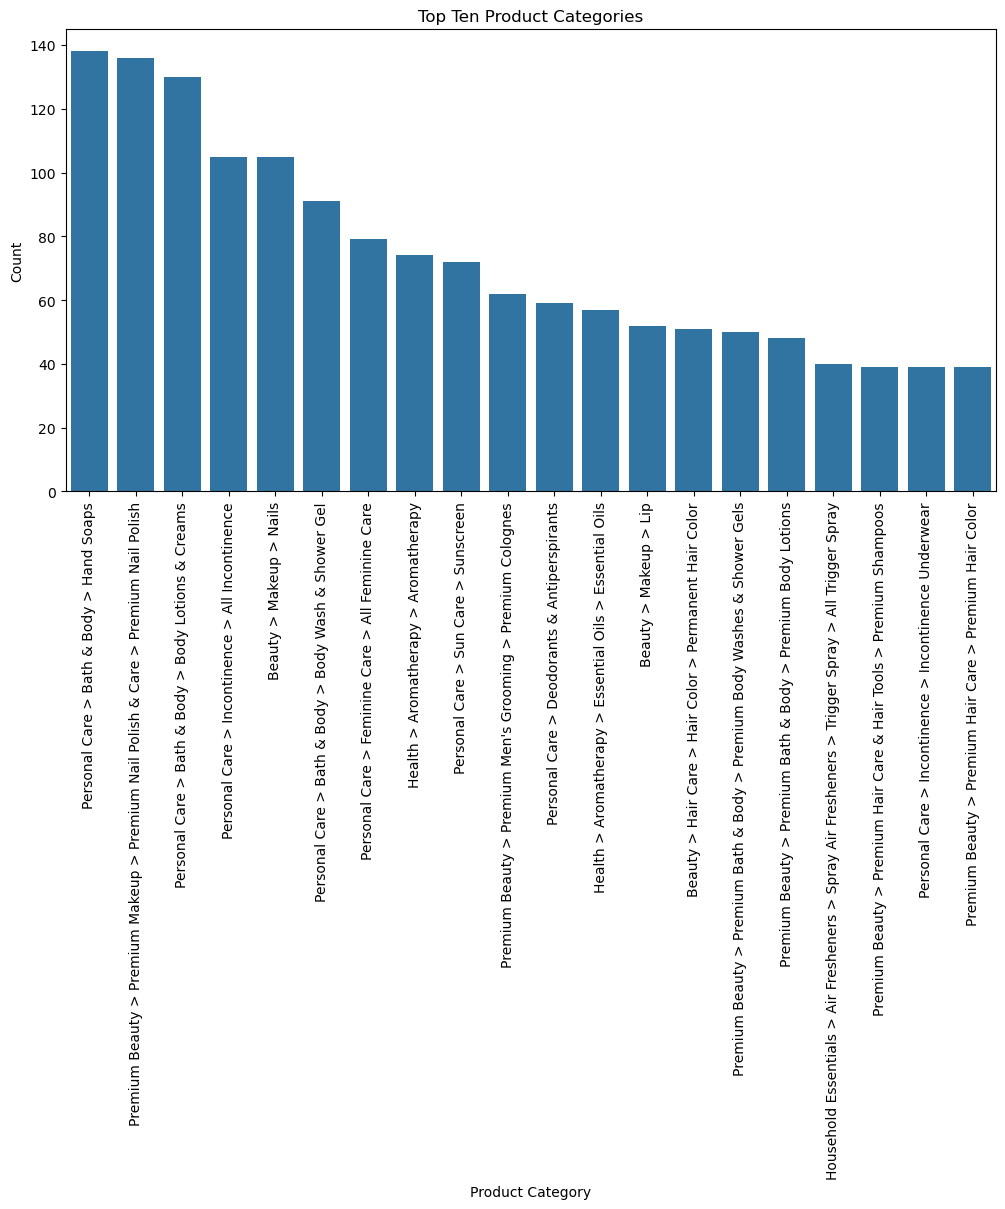

In [57]:
# Get the top product categories
top_ten_categories = train_data['Category'].value_counts().nlargest(20)

# Plot the top ten categories
plt.figure(figsize=(12, 6))
sns.barplot(x=top_ten_categories.index, y=top_ten_categories.values)
plt.xticks(rotation=90)
plt.title('Top Ten Product Categories')
plt.xlabel('Product Category')
plt.ylabel('Count')
plt.show()


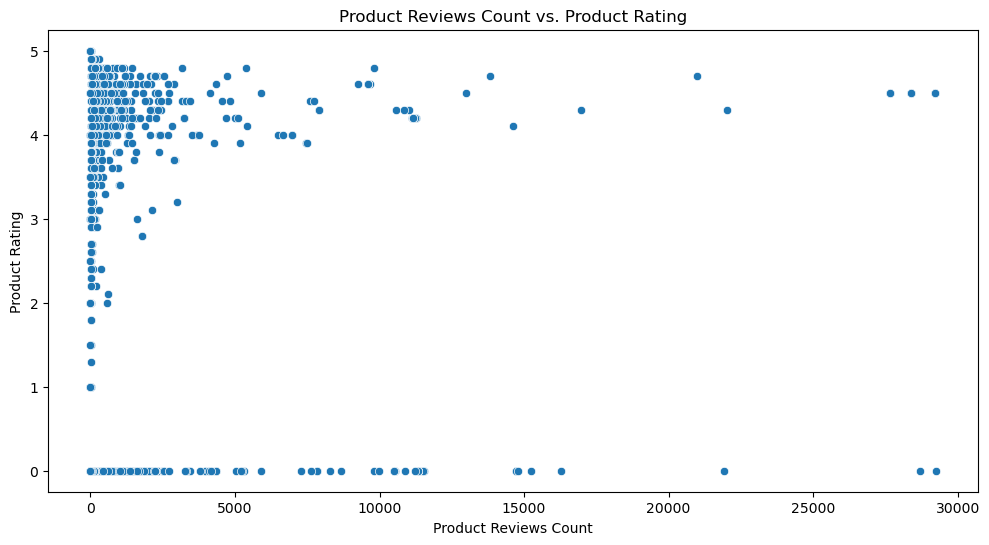

In [58]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=train_data, x='ReviewCount', y='Rating')
plt.title('Product Reviews Count vs. Product Rating')
plt.xlabel('Product Reviews Count')
plt.ylabel('Product Rating')
plt.show()


<Axes: xlabel='Rating'>

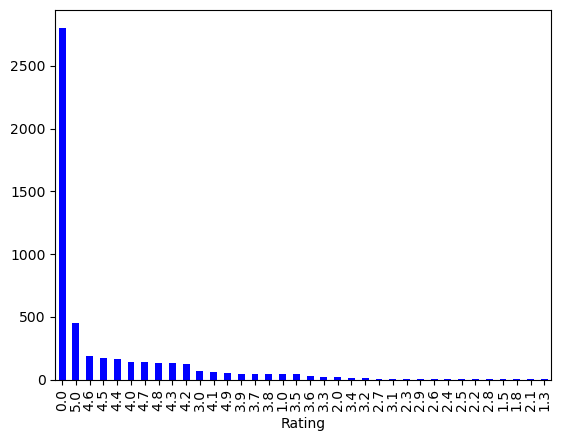

In [59]:
# most rated counts
train_data['Rating'].value_counts().plot(kind='bar',color='blue')

# updating tags and using the other columns 

In [60]:
train_data["Tags"]

0       OPI Infinite Shine, Nail Lacquer Nail Polish, ...
1       Nice 'n Easy Permanent Color, 111 Natural Medi...
2       Clairol Nice 'N Easy Permanent Color 7/106A Na...
3       Kokie Professional Matte Lipstick, Hot Berry, ...
4       Gillette TRAC II Plus Razor Blade Refills, Fit...
                              ...                        
4995    Garden Mint Room Spray (Double Strength), 4 ou...
4996    Garnier Nutrisse Nourishing Hair Color Creme (...
4997    Nail File Electric Drill, 6 in 1 Professional ...
4998    Creed Love In Black Hair And Body Wash 6.8oz/2...
4999                    Foundation, Wal-mart, Walmart.com
Name: Tags, Length: 5000, dtype: object

In [61]:
# using NLTK
nltk.download('punkt')
nltk.download('stopwords')

# set stopwords to english 
stop_words = set(stopwords.words('english'))

def clean_and_extract_tags_nltk(text):
    tokens = word_tokenize(text.lower()) # tokenize after its in lowercase 
    tags = [token for token in tokens if token.isalnum() and token not in stop_words] # remove stop words and add it to a list 
    return ', '.join(tags)    #join the list and return a string 


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/mohamedfadhil/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mohamedfadhil/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [62]:
columns_to_extract_tags_from = ['Category', 'Brand', 'Description']

for column in columns_to_extract_tags_from:
    train_data[column] = train_data[column].apply(clean_and_extract_tags_nltk)


In [63]:
# Concatenate the cleaned tags from all relevant columns
train_data['Tags'] = train_data[columns_to_extract_tags_from].apply(lambda row: ', '.join(row), axis=1)

In [64]:
train_data["Tags"]

0       premium, beauty, premium, makeup, premium, nai...
1       beauty, hair, care, hair, color, auburn, hair,...
2       beauty, hair, care, hair, color, permanent, ha...
3       beauty, makeup, lip, kokie, cosmetics, calling...
4       seasonal, stock, essentials, personal, care, s...
                              ...                        
4995    household, essentials, air, fresheners, spray,...
4996    beauty, hair, care, hair, color, permanent, ha...
4997    beauty, makeup, nails, stoneway, multifunction...
4998    premium, beauty, premium, bath, body, premium,...
4999    beauty, makeup, face, makeup, face, makeup, br...
Name: Tags, Length: 5000, dtype: object

# Rating Base Recommendations System

In [65]:
# mean rating (C)
C = train_data['Rating'].mean() 

# minimum number of reviews (m)
m = train_data['ReviewCount'].quantile(0.75)  # 75th percentile

# average rating for each product
average_ratings = train_data.groupby(['Name', 'ReviewCount', 'Brand', 'ImageURL', 'Tags'])['Rating'].mean().reset_index()

# weighted rating for each product
def weighted_rating(row, m=m, C=C):
    v = row['ReviewCount']  # reviews for the product
    R = row['Rating']  #  avg rating for the product
    # Calculate 
    return (v / (v + m)) * R + (m / (v + m)) * C

# Apply the weighted rating to data
average_ratings['Weighted Rating'] = average_ratings.apply(weighted_rating, axis=1)

# Sort the products by the weighted rating
top_rated_items = average_ratings.sort_values(by='Weighted Rating', ascending=False)

# top products with the highest weighted ratings
rating_base_recommendation = top_rated_items.head(20)

In [66]:
print("Rating Base Recommendation System: (Trending Products)")
rating_base_recommendation

Rating Base Recommendation System: (Trending Products)


,Name,ReviewCount,Brand,ImageURL,Tags,Rating,Weighted Rating
3674,"Pine-Sol All-Purpose Cleaner, Lemon, 144 oz, B...",9806.0,,https://i5.walmartimages.com/asr/cf14ba1d-834d...,"household, essentials, cleaning, supplies, cle...",4.8,4.782196
1116,"Cascade Platinum ActionPacs, Dishwasher Deterg...",5388.0,cascade,https://i5.walmartimages.com/asr/e42f8558-9bff...,"household, essentials, cleaning, supplies, dis...",4.8,4.767758
1942,"Gain Original 96 Loads, Liquid Laundry Deterge...",3175.0,gain,https://i5.walmartimages.com/asr/30977d3c-c744...,"household, essentials, laundry, laundry, deter...",4.8,4.745704
3675,"Pine-Sol Multi-Surface Cleaner, Original, 144 ...",20997.0,clorox,https://i5.walmartimages.com/asr/3e98414e-3779...,"household, essentials, cleaning, supplies, cle...",4.7,4.691944
1983,Garnier Whole Blends Repairing Shampoo Honey T...,13809.0,garnier,https://i5.walmartimages.com/asr/e30b8e1a-5538...,"beauty, hair, care, hair, care, brands, garnie...",4.7,4.687769
1549,"Dixie Everyday Paper Snack or Dessert Plates, ...",1446.0,dixie,https://i5.walmartimages.com/asr/f5cf70ac-0954...,"household, essentials, paper, plastic, disposa...",4.8,4.683379
4949,"essie nail polish, bahama mama, purple nail po...",4727.0,essie,https://i5.walmartimages.com/asr/1c5cca0f-e8dd...,"beauty, nail, care, nail, polish, nail, polish...",4.7,4.664565
2317,Johnsons CottonTouch Newborn Baby Wash & Shamp...,1151.0,johnson,https://i5.walmartimages.com/asr/f8f635a0-fa1a...,"baby, health, safety, baby, bath, baby, shampo...",4.8,4.654976
3445,"Oral-B 7000 Smartseries Electric Toothbrush, 3...",1104.0,,https://i5.walmartimages.com/asr/c684ca52-d5f9...,"seasonal, last, minute, gifts, , smartseries, ...",4.8,4.649122
1596,Dove go fresh Beauty Bar Cucumber and Green Te...,1096.0,dove,https://i5.walmartimages.com/asr/47014ff8-67d6...,"personal, care, bath, body, bar, soap, dove, d...",4.8,4.648078


In [67]:
# evaluvate MSE
y_true = rating_base_recommendation['Rating'].values  # Actual ratings
y_pred = rating_base_recommendation['Weighted Rating'].values  # Predicted ratings from your weighted rating function

mse_value = mean_squared_error(y_true, y_pred)
print(f"MSE for rating predictions: {mse_value}")

MSE for rating predictions: 0.01154336917700251


In [68]:
# save the trending data set 
rating_base_recommendation.to_csv('models/trending_products.csv', index=False)

# User Preferences or Items similarities
### Content Base Recommendation system

In [69]:
#set tfidf 
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix_content = tfidf_vectorizer.fit_transform(train_data['Tags'])
#cosine similarity matrix
cosine_similarities_content = cosine_similarity(tfidf_matrix_content,tfidf_matrix_content)

In [70]:
item_name = 'OPI Infinite Shine, Nail Lacquer Nail Polish, Bubble Bath'

# if same product available more than 1 then take the first index 
item_index = train_data[train_data['Name']==item_name].index[0]

In [71]:
similar_items = list(enumerate(cosine_similarities_content[item_index]))
similar_items = sorted(similar_items, key=lambda x:x[1], reverse=True)
top_similar_items = similar_items[1:10]

recommended_items_indics = [x[0] for x in top_similar_items]

In [72]:
train_data.iloc[recommended_items_indics][['Name','ReviewCount','Brand']]

,Name,ReviewCount,Brand
156,OPI Nail Lacquer Polish .5oz/15mL - This Gown ...,0.0,opi
184,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,0.0,opi
205,OPI Nail Lacquer - Dont Bossa Nova Me Around -...,0.0,opi
237,OPI Infinite Shine 2 Polish - ISL P33 - Alpaca...,5.0,opi
325,OPI Gel Polish Fall 2019 Scotland Collection G...,1.0,opi
375,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,1.0,opi
402,"OPI Nail Polish, Strawberry Margarita, 0.5 Fl Oz",57.0,opi
706,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,1.0,opi
886,OPI- Nail Lacquer-GelColor - &quotLiv&quotin t...,0.0,opi


# Function for content_based_recommendations

In [73]:
def content_based_recommendations(train_data, item_name, top_n=10):
    # Check if the item name exists in the training data
    if item_name not in train_data['Name'].values:
        print(f"Item '{item_name}' not found in the training data.")
        return pd.DataFrame()

   
   # TFIDF vectorizer
    tfidf_vectorizer = TfidfVectorizer(stop_words='english') 
    tfidf_matrix_content = tfidf_vectorizer.fit_transform(train_data['Tags'])

    # cosine similarity 
    cosine_similarities_content = cosine_similarity(tfidf_matrix_content, tfidf_matrix_content)

    # Find the index of the item
    item_index = train_data[train_data['Name'] == item_name].index[0]

    similar_items = list(enumerate(cosine_similarities_content[item_index]))
    similar_items = sorted(similar_items, key=lambda x: x[1], reverse=True) #decending order

    top_similar_items = similar_items[0:top_n+1]

    # indices of the top similar items
    recommended_item_indices = [x[0] for x in top_similar_items]

    # details 
    recommended_items_details = train_data.iloc[recommended_item_indices][['ID','Name', 'ReviewCount', 'Brand', 'ImageURL', 'Rating','ProdID']]

    return recommended_items_details

In [74]:
# Example: Get content-based recommendations for a specific item
item_name = 'OPI Infinite Shine, Nail Lacquer Nail Polish, Bubble Bath'
content_based_rec = content_based_recommendations(train_data, item_name, top_n=8)

content_based_rec

,ID,Name,ReviewCount,Brand,ImageURL,Rating,ProdID
0,1.705737e+09,"OPI Infinite Shine, Nail Lacquer Nail Polish, ...",0.0,opi,https://i5.walmartimages.com/asr/0e1f4c51-c1a4...,0.0,2.0
156,9.000000e+01,OPI Nail Lacquer Polish .5oz/15mL - This Gown ...,0.0,opi,https://i5.walmartimages.com/asr/71caed3f-5f83...,0.0,58.0
184,4.133000e+03,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,0.0,opi,https://i5.walmartimages.com/asr/2d6f5147-53a8...,0.0,2.0
205,7.956490e+05,OPI Nail Lacquer - Dont Bossa Nova Me Around -...,0.0,opi,https://i5.walmartimages.com/asr/fd1195d2-8d8d...,0.0,7.0
237,4.300000e+01,OPI Infinite Shine 2 Polish - ISL P33 - Alpaca...,5.0,opi,https://i5.walmartimages.com/asr/7426eb5c-1690...,0.0,4103.0
325,3.000000e+00,OPI Gel Polish Fall 2019 Scotland Collection G...,1.0,opi,https://i5.walmartimages.com/asr/79bbbd9f-9a89...,0.0,4.0
375,9.940000e+02,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,1.0,opi,https://i5.walmartimages.com/asr/744e869c-3500...,5.0,3402.0
402,9.000000e+00,"OPI Nail Polish, Strawberry Margarita, 0.5 Fl Oz",57.0,opi,https://i5.walmartimages.com/asr/b95676e5-96ab...,4.4,58.0
706,5.400539e+06,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,1.0,opi,https://i5.walmartimages.com/asr/c7ba4815-52f7...,5.0,94.0


In [75]:
# Example: Get content-based recommendations for a specific item
item_name = 'Kokie Professional Matte Lipstick, Hot Berry, 0.14 fl oz'
content_based_rec = content_based_recommendations(train_data, item_name, top_n=8)

content_based_rec

,ID,Name,ReviewCount,Brand,ImageURL,Rating,ProdID
3,4.0,"Kokie Professional Matte Lipstick, Hot Berry, ...",0.0,"kokie, cosmetics",https://i5.walmartimages.com/asr/25b4b467-bc61...,0.0,3.0
3406,66061886.0,"Kokie Professional Matte Lipstick, Firecracker...",0.0,"kokie, cosmetics",https://i5.walmartimages.com/asr/8312221b-ed22...,0.0,7402.0
546,3.0,"Kokie Professional Matte Lipstick, Kiss Me, 0....",0.0,"kokie, cosmetics",https://i5.walmartimages.com/asr/27dd82a2-2b9c...,0.0,6.0
2406,2.0,"L.A. Colors Matte Lipstick, Tender Matte",3.0,colors,https://i5.walmartimages.com/asr/271264fb-e8c3...,3.7,4.0
4050,591232.0,Kokie Professional Lip Poudre Liquid Matte Liq...,7.0,"kokie, cosmetics",https://i5.walmartimages.com/asr/fdd7498c-319f...,3.4,66787.0
1559,12.0,"LOreal Paris Colour Riche Matte Lip Liner, Mat...",495.0,paris,https://i5.walmartimages.com/asr/baf97085-7231...,4.4,4.0
4084,309.0,e.l.f. Mad for Matte 4 Piece Lip Color Set,0.0,cosmetics,https://i5.walmartimages.com/asr/e2d30304-edc9...,0.0,5696567.0
2873,317.0,Kokie Professional Lip Poudre Liquid Matte Liq...,7.0,"kokie, cosmetics",https://i5.walmartimages.com/asr/31c99d9b-ea11...,3.4,7.0
4872,6.0,"L.A. Colors Matte Lipstick, Torrid Matte",8.0,colors,https://i5.walmartimages.com/asr/62d6d9fa-eee1...,4.8,73.0


# Collaborative Filtering (User Item Similarity)

In [76]:
user_item_matrix = train_data.pivot_table(index='ID', columns='ProdID', values='Rating',aggfunc='mean').fillna(0).astype(int)
user_item_matrix.head(5)

ProdID,0.000000e+00,1.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00,5.000000e+00,6.000000e+00,7.000000e+00,8.000000e+00,9.000000e+00,...,1.007940e+42,1.007940e+42,1.008730e+42,1.030521e+42,1.030521e+42,1.030521e+42,1.076430e+42,3.002240e+42,5.002240e+42,5.005509e+42
ID,,,,,,,,,,,,,,,,,,,,,
0.0,2,1,2,1,1,0,2,1,1,1,...,0,0,0,0,0,0,5,0,0,0
1.0,1,0,2,2,0,2,3,2,0,2,...,0,4,0,0,5,0,0,0,0,0
2.0,1,1,3,1,2,1,0,2,1,1,...,0,3,0,0,0,0,0,0,0,4
3.0,1,1,1,2,0,3,1,0,0,3,...,0,0,0,0,0,0,0,0,0,0
4.0,3,0,2,1,1,1,0,2,1,3,...,0,1,0,0,0,0,0,0,0,0


In [77]:
user_similarity = cosine_similarity(user_item_matrix)

In [78]:
target_user_id = 4
target_user_index = user_item_matrix.index.get_loc(target_user_id)

In [79]:
user_similarities = user_similarity[target_user_index]

similar_user_indices = user_similarities.argsort()[::-1][1:]    # convert to decending order and removing the first one (itself)

In [80]:
recommend_items = []

for user_index in similar_user_indices:
    rated_by_similar_user = user_item_matrix.iloc[user_index]
    not_rated_by_target_user = (rated_by_similar_user==0) & (user_item_matrix.iloc[target_user_index]==0)
    
    recommend_items.extend(user_item_matrix.columns[not_rated_by_target_user][:10])

recommended_items_details = train_data[train_data['ProdID'].isin(recommend_items)][['Name','ReviewCount','Brand','ImageURL','Rating']]

In [81]:
recommended_items_details.head(10)

,Name,ReviewCount,Brand,ImageURL,Rating
15,Clairol Natural Instincts Demi-Permanent Hair ...,2935.0,clairol,https://i5.walmartimages.com/asr/00a6e54a-e431...,3.7
33,"DenTek Kids Fun Flossers, Removes Food & Plaqu...",3.0,dentek,https://i5.walmartimages.com/asr/de6e52eb-6e18...,0.0
61,"COVERGIRL Exhibitionist Cream Lipstick, 395 Da...",713.0,covergirl,https://i5.walmartimages.com/asr/95076ec0-ffbd...,4.3
64,Neutrogena SkinClearing Oil-Free Liquid Founda...,741.0,neutrogena,https://i5.walmartimages.com/asr/fd4d78d8-310a...,4.2
69,Design Essentials Natural Coconut & Monoi Curl...,1.0,"design, essentials",https://i5.walmartimages.com/asr/ff2dba1d-0c02...,5.0
78,"Paul Sebastian Fine Cologne Spray, Cologne for...",28.0,"paul, sebastian",https://i5.walmartimages.com/asr/03d08a07-18d7...,4.8
85,"BioAstin Hawaiian Astaxanthin, Vegan, 12mg, 75 Ct",3.0,bioastin,https://i5.walmartimages.com/asr/6da9e238-b19e...,5.0
92,"Bytewise Organic Moringa Leaf Powder, 12 Oz",0.0,bytewise,https://i5.walmartimages.com/asr/076f2b3f-fdc3...,0.0
94,Ag Hair Cosmetics Ultradynamics Extra-Firm Fin...,0.0,"ag, hair",https://i5.walmartimages.com/asr/5d217d98-a385...,0.0
108,OPI Nail Dipping Powder Perfection Combo - Liq...,1.0,opi,https://i5.walmartimages.com/asr/ef1607ee-5bdb...,3.0


# Function for collaborative_filtering_recommendations

In [82]:
def collaborative_filtering_recommendations(train_data, target_user_id, top_n=10):
    # Create the user-item matrix
    user_item_matrix = train_data.pivot_table(index='ID', columns='ProdID', values='Rating', aggfunc='mean').fillna(0)

    # Calculate the user similarity matrix using cosine similarity
    user_similarity = cosine_similarity(user_item_matrix)

    # Find the index of the target user in the matrix
    target_user_index = user_item_matrix.index.get_loc(target_user_id)

    # Get the similarity scores for the target user
    user_similarities = user_similarity[target_user_index]

    # Sort the users by similarity in descending order (excluding the target user)
    similar_users_indices = user_similarities.argsort()[::-1][1:]

    # Generate recommendations based on similar users
    recommended_items = []

    for user_index in similar_users_indices:
        # Get items rated by the similar user but not by the target user
        rated_by_similar_user = user_item_matrix.iloc[user_index]
        not_rated_by_target_user = (rated_by_similar_user == 0) & (user_item_matrix.iloc[target_user_index] == 0)

        # Extract the item IDs of recommended items
        recommended_items.extend(user_item_matrix.columns[not_rated_by_target_user][:top_n])

    # Get the details of recommended items
    recommended_items_details = train_data[train_data['ProdID'].isin(recommended_items)][['Name', 'ReviewCount', 'Brand', 'ImageURL', 'Rating']]

    return recommended_items_details.head(top_n)

# Example usage
target_user_id = 4
top_n = 5
collaborative_filtering_rec = collaborative_filtering_recommendations(train_data, target_user_id)
print(f"Top {top_n} recommendations for User {target_user_id}:")
collaborative_filtering_rec

Top 5 recommendations for User 4:


,Name,ReviewCount,Brand,ImageURL,Rating
61,"COVERGIRL Exhibitionist Cream Lipstick, 395 Da...",713.0,covergirl,https://i5.walmartimages.com/asr/95076ec0-ffbd...,4.3
85,"BioAstin Hawaiian Astaxanthin, Vegan, 12mg, 75 Ct",3.0,bioastin,https://i5.walmartimages.com/asr/6da9e238-b19e...,5.0
86,LOreal Paris Feria Multi-Faceted Shimmering Pe...,2144.0,paris,https://i5.walmartimages.com/asr/c229026a-2b75...,3.1
108,OPI Nail Dipping Powder Perfection Combo - Liq...,1.0,opi,https://i5.walmartimages.com/asr/ef1607ee-5bdb...,3.0
144,Covidien Curity Maternity Pad Heavy 4.33&quot ...,0.0,covidien,https://i5.walmartimages.com/asr/e4e38217-ed43...,0.0
155,"Crest 3D White Brilliance Mouthwash, Alcohol F...",63.0,crest,https://i5.walmartimages.com/asr/1fcc5525-9ae3...,0.0
174,COVERGIRL Outlast All-Day Moisturizing Lip Col...,36.0,covergirl,https://i5.walmartimages.com/asr/4479896f-c6c4...,0.0
193,"Revlon ColorStay Skinny Liquid Liner, 304 Gree...",70.0,revlon,https://i5.walmartimages.com/asr/aa3b20a6-3d6d...,4.5
212,"Comvita Certified UMF 20+ Manuka Honey, Raw & ...",0.0,comvita,https://i5.walmartimages.com/asr/3cdc1498-a2ac...,0.0
241,"Ahava Mens Mineral Hand Cream, 3.4 Oz",0.0,ahava,https://i5.walmartimages.com/asr/f74e4bb7-47d3...,0.0


# Hybrid Recommendations

In [83]:
# Hybrid Recommendations (Combine Content-Based and Collaborative Filtering)
def hybrid_recommendations(train_data,target_user_id, item_name, top_n=10):
    # Get content-based recommendations
    content_based_rec = content_based_recommendations(train_data,item_name, top_n)

    # Get collaborative filtering recommendations
    collaborative_filtering_rec = collaborative_filtering_recommendations(train_data,target_user_id, top_n)
    
    # Merge and deduplicate the recommendations
    hybrid_rec = pd.concat([content_based_rec, collaborative_filtering_rec]).drop_duplicates()
    
    return hybrid_rec.head(10)

In [84]:
# Example usage: Get hybrid recommendations for a specific user and item
target_user_id = 4 # Change this to the user_id you want recommendations for
item_name = "OPI Nail Lacquer Polish .5oz/15mL - This Gown Needs A Crown NL U11"  # Change this to the item name

hybrid_rec = hybrid_recommendations(train_data,target_user_id, item_name, top_n=10)

print(f"Top 10 Hybrid Recommendations for User {target_user_id} and Item '{item_name}':")
hybrid_rec

Top 10 Hybrid Recommendations for User 4 and Item 'OPI Nail Lacquer Polish .5oz/15mL - This Gown Needs A Crown NL U11':


,ID,Name,ReviewCount,Brand,ImageURL,Rating,ProdID
0,1.705737e+09,"OPI Infinite Shine, Nail Lacquer Nail Polish, ...",0.0,opi,https://i5.walmartimages.com/asr/0e1f4c51-c1a4...,0.0,2.0
156,9.000000e+01,OPI Nail Lacquer Polish .5oz/15mL - This Gown ...,0.0,opi,https://i5.walmartimages.com/asr/71caed3f-5f83...,0.0,58.0
184,4.133000e+03,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,0.0,opi,https://i5.walmartimages.com/asr/2d6f5147-53a8...,0.0,2.0
205,7.956490e+05,OPI Nail Lacquer - Dont Bossa Nova Me Around -...,0.0,opi,https://i5.walmartimages.com/asr/fd1195d2-8d8d...,0.0,7.0
237,4.300000e+01,OPI Infinite Shine 2 Polish - ISL P33 - Alpaca...,5.0,opi,https://i5.walmartimages.com/asr/7426eb5c-1690...,0.0,4103.0
325,3.000000e+00,OPI Gel Polish Fall 2019 Scotland Collection G...,1.0,opi,https://i5.walmartimages.com/asr/79bbbd9f-9a89...,0.0,4.0
375,9.940000e+02,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,1.0,opi,https://i5.walmartimages.com/asr/744e869c-3500...,5.0,3402.0
402,9.000000e+00,"OPI Nail Polish, Strawberry Margarita, 0.5 Fl Oz",57.0,opi,https://i5.walmartimages.com/asr/b95676e5-96ab...,4.4,58.0
706,5.400539e+06,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,1.0,opi,https://i5.walmartimages.com/asr/c7ba4815-52f7...,5.0,94.0
886,3.600000e+01,OPI- Nail Lacquer-GelColor - &quotLiv&quotin t...,0.0,opi,https://i5.walmartimages.com/asr/98b4194c-e026...,0.0,7.0


In [85]:
# Example usage: Get hybrid recommendations for a specific user and item
target_user_id = 10 # Change this to the user_id you want recommendations for
item_name = 'Black Radiance Perfect Tone Matte Lip Crème, Succulent Plum'

hybrid_rec = hybrid_recommendations(train_data,target_user_id, item_name, top_n=10)

print(f"Top 10 Hybrid Recommendations for User {target_user_id} and Item '{item_name}':")
hybrid_rec

Top 10 Hybrid Recommendations for User 10 and Item 'Black Radiance Perfect Tone Matte Lip Crème, Succulent Plum':


,ID,Name,ReviewCount,Brand,ImageURL,Rating,ProdID
100,11.0,"Black Radiance Perfect Tone Matte Lip Crème, S...",27.0,"black, radiance",https://i5.walmartimages.com/asr/a1fdace5-049c...,4.9,0.0
896,4.0,"Black Radiance Perfect Tone Lip Color, Vintage...",78.0,"black, radiance",https://i5.walmartimages.com/asr/485f26b4-a19a...,4.7,56014.0
2496,0.0,"Black Radiance Perfect Tone Lip Color, Hollywo...",18.0,"black, radiance",https://i5.walmartimages.com/asr/fe3da48f-5142...,4.3,6.0
3,4.0,"Kokie Professional Matte Lipstick, Hot Berry, ...",0.0,"kokie, cosmetics",https://i5.walmartimages.com/asr/25b4b467-bc61...,0.0,3.0
3406,66061886.0,"Kokie Professional Matte Lipstick, Firecracker...",0.0,"kokie, cosmetics",https://i5.walmartimages.com/asr/8312221b-ed22...,0.0,7402.0
2406,2.0,"L.A. Colors Matte Lipstick, Tender Matte",3.0,colors,https://i5.walmartimages.com/asr/271264fb-e8c3...,3.7,4.0
4050,591232.0,Kokie Professional Lip Poudre Liquid Matte Liq...,7.0,"kokie, cosmetics",https://i5.walmartimages.com/asr/fdd7498c-319f...,3.4,66787.0
2873,317.0,Kokie Professional Lip Poudre Liquid Matte Liq...,7.0,"kokie, cosmetics",https://i5.walmartimages.com/asr/31c99d9b-ea11...,3.4,7.0
4872,6.0,"L.A. Colors Matte Lipstick, Torrid Matte",8.0,colors,https://i5.walmartimages.com/asr/62d6d9fa-eee1...,4.8,73.0
1300,77.0,"e.l.f. Liquid Matte Lipstick, Tea Rose",476.0,cosmetics,https://i5.walmartimages.com/asr/58220de4-3875...,4.1,12.0


In [86]:
# Merge the average_ratings with train_data
train_data = train_data.merge(average_ratings[['Name', 'Weighted Rating']], on='Name', how='left')


In [87]:

threshold = 3.5
train_data['Relevant'] = np.where(train_data['Rating'] >= threshold, 1, 0)

train_data['PredRelevant'] = np.where(train_data['Weighted Rating'] >= threshold, 1, 0)

y_true_relevance = train_data['Relevant']
# the actual and predicted relevance value
y_pred_relevance = train_data['PredRelevant']

# Calculate precision, recall, and F1 score
precision_val = precision_score(y_true_relevance, y_pred_relevance)
recall_val = recall_score(y_true_relevance, y_pred_relevance)
f1_val = f1_score(y_true_relevance, y_pred_relevance)

print(f"Precision: {precision_val}")
print(f"Recall: {recall_val}")
print(f"F1 Score: {f1_val}")



Precision: 0.9872813990461049
Recall: 0.3029268292682927
F1 Score: 0.46360582306830905
